# Exploratory data analysis

Классификация: LogR, SVM, NN

In [1]:
# подключаем облако
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Информация о наборе данных

В качестве датасета используем Rice (Cammeo and Osmancik). (2019). UCI Machine Learning Repository. https://doi.org/10.24432/C5MW4Z.

Было сделано 3810 изображений зерен двух сортов риса, после обработки которых получено 7 морфологических признаков зерна:

1. Area: площадь - количество пикселей в границах рисового зерна.
2. Perimeter: периметр -  расстояние между пикселями вокруг границ рисового зерна.
3. Major_Axis_Length: длина по главной оси.
4. Minor_Axis_Length: длина по малой оси.
5. Eccentricity: эксцентриситет.
6. Convex_Area: количество пикселей наименьшей выпуклой оболочки области, образованной рисовым зерном.
7. Extent: отношение области, образованной рисовым зерном, к пикселям ограничивающей рамки.
8. Class: сорт Османчик и Каммео.

In [2]:
# подключим стандартные библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Загрузка данных

In [3]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Rice_Dataset_Commeo_and_Osmancik/Rice_Cammeo_Osmancik.xlsx')
df.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896,Cammeo
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436,Cammeo
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259,Cammeo
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669,Cammeo
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024,Cammeo


Проверим на наличие пропусков в данных.

In [4]:
df.isna().max()

Area                 False
Perimeter            False
Major_Axis_Length    False
Minor_Axis_Length    False
Eccentricity         False
Convex_Area          False
Extent               False
Class                False
dtype: bool

Проанализируем скатерплот.

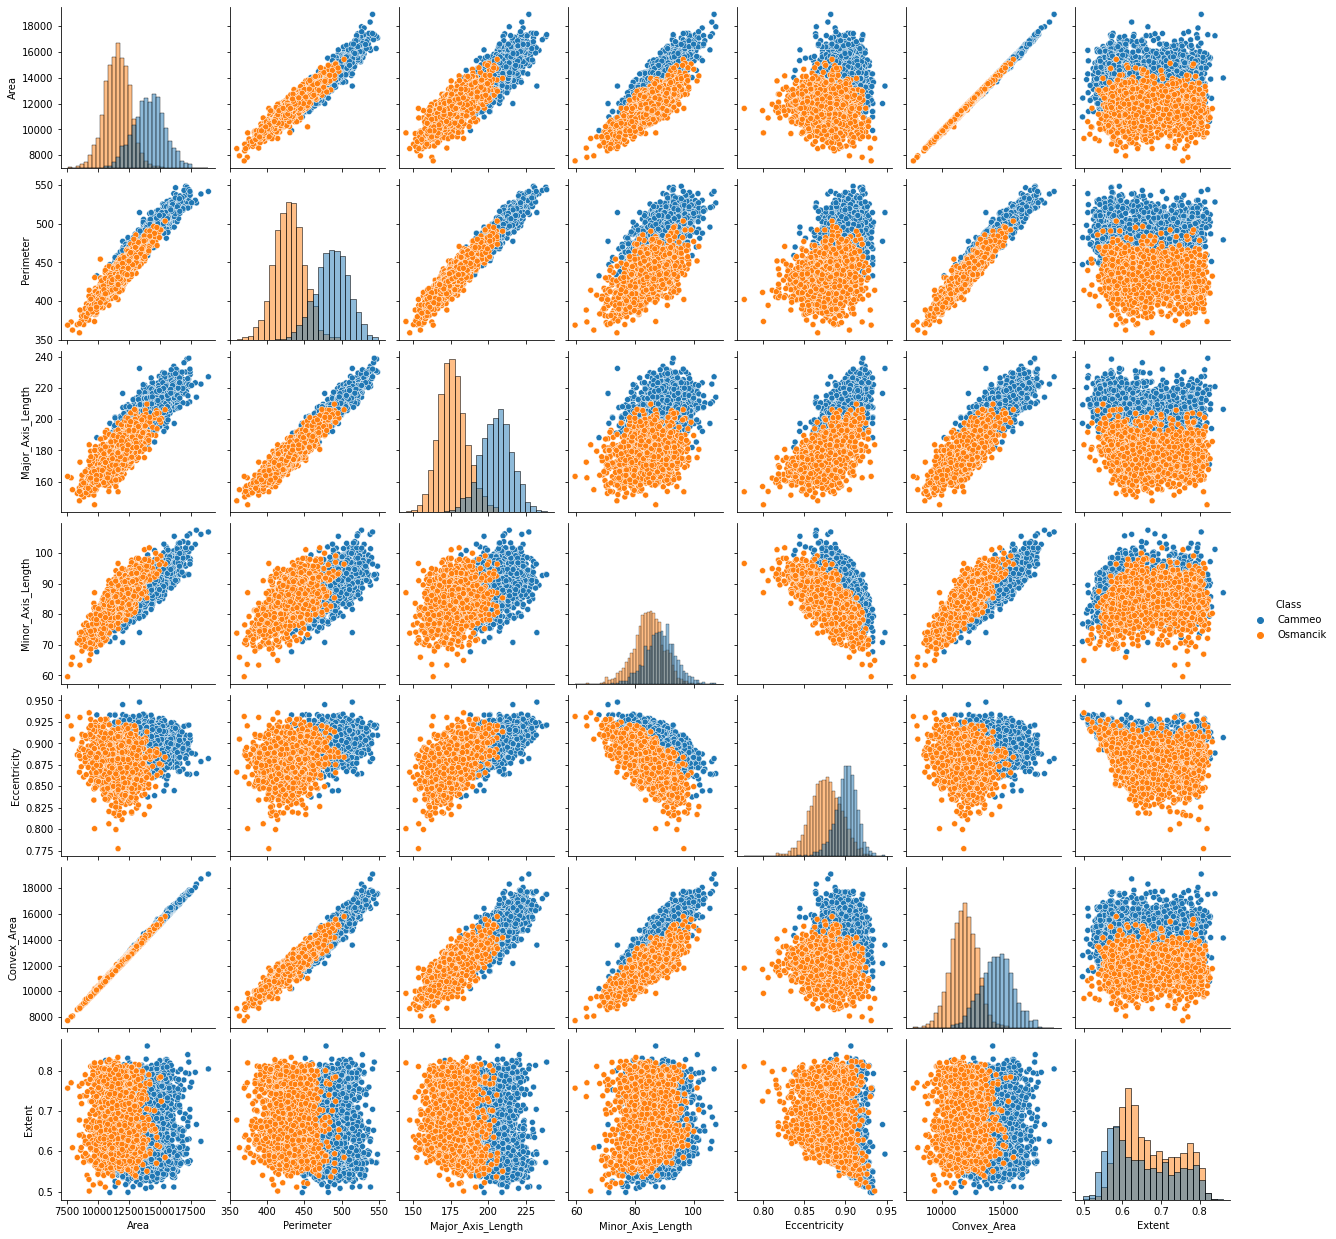

In [5]:
sns.pairplot(df, hue = 'Class', diag_kind='hist')

Явных выбросов нет, длинных правых хвостов также не наблюдаем.

Разделим наши данные на тренирочные и тестовые в соотношении 4:1. Воспользуемся библиотекой **scikit learn**, которая обладает широкими возможностями и  предоставляет большое количесво алгоритмов и методов для задач машинного обучения. Для равномерного распределения сортов по датасетам добавим параметр `stratify`.

In [6]:
from sklearn. model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('Class', axis=1), 
    df.Class.map(lambda x : 1 if x == 'Cammeo' else 0), # заменим сорт числовым кодом
    test_size=1/5, 
    random_state=4399, 
    stratify=df.Class
)

Посмотрим насколько сбалансированы классы.

In [7]:
y_train.value_counts()

0    1744
1    1304
Name: Class, dtype: int64

Небольшой дисбаланс, пересемлируем малый класс.

In [8]:
from sklearn.utils import resample
n_samples = y_train.value_counts().max() - y_train.value_counts().min()
resampled = resample(X_train.iloc[X_train.index[y_train == 1],:],      
                     n_samples=n_samples,
                     replace=True,  
                     random_state=4399)
X_train_resampled = pd.concat([X_train, resampled],
                              ignore_index = True)
y_train_resampled = y_train.append(pd.Series(1).repeat(n_samples),
                                   ignore_index = True)
y_train_resampled.value_counts()

0    1744
1    1744
dtype: int64

Стандартизуем данные, чтобы нивелировать разный масштаб признаков.

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_resampled), columns = X_train_resampled.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

# Логистическая регрессия

Сравним модели с разными методами оптимизации.

In [10]:
from sklearn.linear_model import LogisticRegression
logreg_sag = LogisticRegression(penalty = 'none', # отключение регуляризации
                                max_iter = 500, # максимальное число итераций до сходимости
                                random_state = 4399, # параметр контроля случайности
                                solver = 'sag') # стохастический градиентный спуск в качестве метода оптимизации
logreg_sag.fit(X_train_scaled, y_train_resampled)

LogisticRegression(max_iter=500, penalty='none', random_state=4399,
                   solver='sag')

In [11]:
logreg_lbfgs = LogisticRegression(penalty = 'none',
                                max_iter = 500, 
                                random_state = 4399,
                                solver = 'lbfgs') # алгоритм Бройдена — Флетчера — Гольдфарба — Шанно c ограниченной памятью
logreg_lbfgs.fit(X_train_scaled, y_train_resampled)

LogisticRegression(max_iter=500, penalty='none', random_state=4399)

Подготовим функции для подсчета метрик качества.

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
def quality_report(expected, actual):
    print("Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nf1_score: {:.3f}\n".format(
        accuracy_score(expected, actual),  # доля правильно классифицированных объектов
        precision_score(expected, actual), # точность
        recall_score(expected, actual), # полнота
        f1_score(expected, actual) # гармоническое среднее
    ))
    print(confusion_matrix(expected, actual),'\n') # матрица неточностей 

Аналогично для построения ROC кривой.


In [13]:
from sklearn.metrics import roc_auc_score, roc_curve
def plot_roc_curve(expected, actual_prob):
    fpr, tpr, _ = roc_curve(expected, actual_prob) # доли ложно положительной классификации и верно предсказанных классов
    score = roc_auc_score(expected, actual_prob) # площадь под кривой ошибок 
    plt.plot(fpr, tpr, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC AUC: {:.5f}'.format(score))
    plt.show()
    print()

Заготовка функции для вывода результатов классификации на тренировочных и тестовых данных.

In [14]:
def print_results(model):
  print(model, "on TRAIN")
  quality_report(y_train, model.predict(X_train_scaled[:-n_samples]))
  plot_roc_curve(y_train, model.predict_proba(X_train_scaled)[:-n_samples,1])
  print(model, "on TEST")
  quality_report(y_test, model.predict(X_test_scaled))
  plot_roc_curve(y_test, model.predict_proba(X_test_scaled)[:,1])

Теперь можем оценить работу обученных выше моделей.

LogisticRegression(max_iter=500, penalty='none', random_state=4399,
                   solver='sag') on TRAIN
Accuracy: 0.926
Precision: 0.889
Recall: 0.945
f1_score: 0.916

[[1590  154]
 [  72 1232]] 



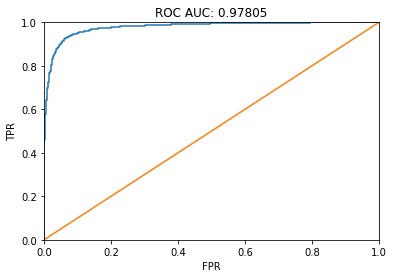


LogisticRegression(max_iter=500, penalty='none', random_state=4399,
                   solver='sag') on TEST
Accuracy: 0.911
Precision: 0.875
Recall: 0.923
f1_score: 0.899

[[393  43]
 [ 25 301]] 



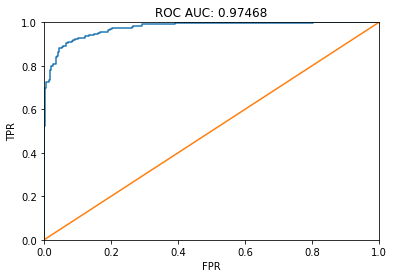

In [15]:
print_results(logreg_sag)

Достаточно высокая точность. Гармоническое среднее и площадь по кривой ошибок близки к единице. Данные хорошо поддаются классификации.

Посмотрим, как отработала вторая модель (в качестве метода оптимизации алгоритм Бройдена — Флетчера — Гольдфарба — Шанно c ограниченной памятью).

LogisticRegression(max_iter=500, penalty='none', random_state=4399) on TRAIN
Accuracy: 0.926
Precision: 0.888
Recall: 0.946
f1_score: 0.916

[[1589  155]
 [  71 1233]] 



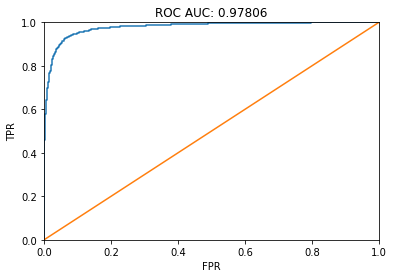


LogisticRegression(max_iter=500, penalty='none', random_state=4399) on TEST
Accuracy: 0.912
Precision: 0.878
Recall: 0.923
f1_score: 0.900

[[394  42]
 [ 25 301]] 



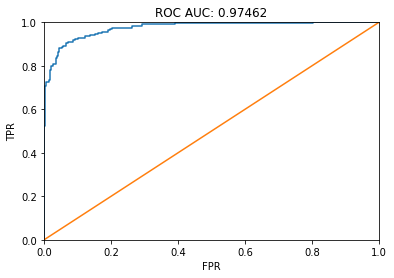

In [16]:
print_results(logreg_lbfgs)

В целом разницы практически нет. Переобучения в обоих моделях не выявлено.

# Метод опорных векторов

Сравним модели с линейно разделяющей плоскостью и полиномиальным ядром.

In [17]:
from sklearn import svm
svm_linear = svm.SVC(kernel='linear', # тип ядра, который будет использоваться в алгоритме
                     probability=True, # вывод оценки вероятности
                     random_state=4399)
svm_linear.fit(X_train_scaled, y_train_resampled)

SVC(kernel='linear', probability=True, random_state=4399)

SVC(kernel='linear', probability=True, random_state=4399) on TRAIN
Accuracy: 0.927
Precision: 0.894
Recall: 0.941
f1_score: 0.917

[[1598  146]
 [  77 1227]] 



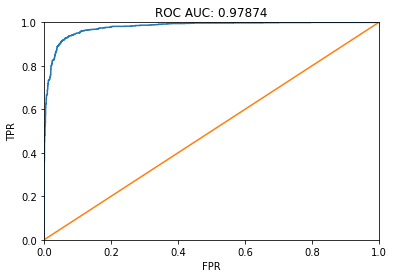


SVC(kernel='linear', probability=True, random_state=4399) on TEST
Accuracy: 0.923
Precision: 0.899
Recall: 0.923
f1_score: 0.911

[[402  34]
 [ 25 301]] 



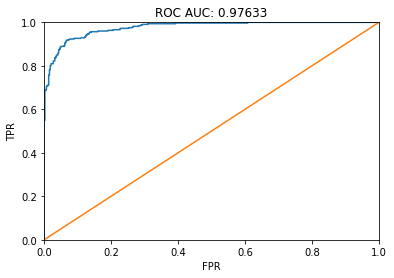

In [18]:
print_results(svm_linear)

Метрики выше, чем у логистической регрессии.

Попробуем полиномиальнео ядро.

In [19]:
svm_poly = svm.SVC(kernel='poly', 
                   degree=3, # cтепень полиномиальной функции ядра 
                   probability=True)
svm_poly.fit(X_train_scaled, y_train_resampled)

SVC(kernel='poly', probability=True)

SVC(kernel='poly', probability=True) on TRAIN
Accuracy: 0.920
Precision: 0.910
Recall: 0.903
f1_score: 0.906

[[1628  116]
 [ 127 1177]] 



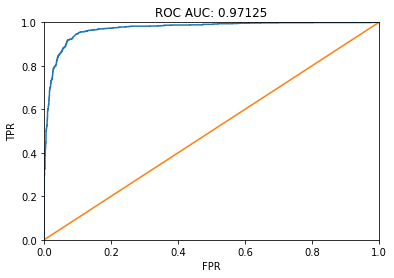


SVC(kernel='poly', probability=True) on TEST
Accuracy: 0.908
Precision: 0.898
Recall: 0.887
f1_score: 0.892

[[403  33]
 [ 37 289]] 



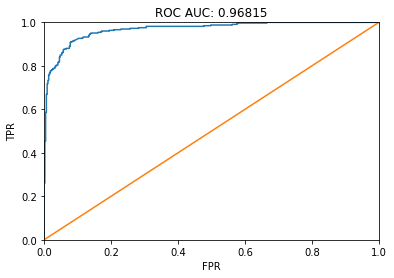

In [20]:
print_results(svm_poly)

Число ошибок увеличилось.

 # Нейронные сети

Воспользуемся перцептроном `MLPClassifier` из библиотеки *scikit learn*.


Сначала посмотрим в целом, насколько быстро можно обучиться до приемлемой точности со стандартными параметрами. 

In [54]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(random_state = 4399, 
                   max_iter=1, # максимальное количество итераций
                   warm_start=True) # повторно используем решение предыдущего вызова для инициализации

Отделим от тренировочных данных 20% для валидационной выборки.

In [55]:
X_subtrain, X_validation, y_subtrain, y_validation = train_test_split(X_train_resampled, y_train_resampled, train_size=4/5, stratify=y_train_resampled)
X_subtrain_scaled = pd.DataFrame(scaler.fit_transform(X_subtrain), columns = X_subtrain.columns)
X_validation_scaled = pd.DataFrame(scaler.transform(X_validation), columns = X_validation.columns)

Нарисуем графики accuracy модели на тестовых и валидационных данных.


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


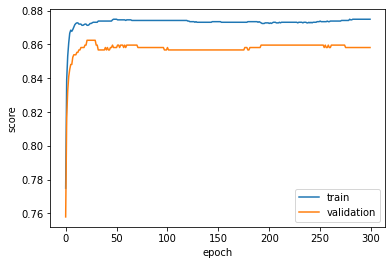

In [56]:
scores = [(nn.fit(X_subtrain_scaled, y_subtrain).score(X_subtrain_scaled, y_subtrain), nn.score(X_validation_scaled, y_validation)) for _ in range(300)]
plt.plot(scores)
plt.ylabel('score')
plt.xlabel('epoch')
plt.legend(['train','validation'])

Доля правильно классифицированных объектов на валидационной выборке после выхода на плато начинает уменьшаться.

Будем искать оптимальные параметры по сетке с помощью кросс-валидации.

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, make_scorer
param_grid = [{'model__hidden_layer_sizes':[(10,),(50,),(100,)], # количество нейронов в скрытом слое
               'model__activation': ['logistic', 'relu'], # функция активации для скрытого слоя
               'model__learning_rate_init': [0.1, 0.01, 0.001], # начальная скорость обучения
               'model__max_iter': [100, 200]}]
grid_search = GridSearchCV(estimator=Pipeline([('scaler', scaler), ('model', MLPClassifier(random_state = 4399))]),
                           param_grid=param_grid, 
                           scoring=make_scorer(accuracy_score), # максимизируем долю правильно классифицированных объектов
                           n_jobs=-1) # использование всех процессоров

Подбираем параметры.

In [46]:
grid_search.fit(X_train_resampled, y_train_resampled)
grid_search.best_params_

{'model__activation': 'logistic',
 'model__hidden_layer_sizes': (50,),
 'model__learning_rate_init': 0.1,
 'model__max_iter': 100}

Обучаем модель.

MLPClassifier(activation='logistic', hidden_layer_sizes=(50,),
              learning_rate_init=0.1, max_iter=100, random_state=4399) on TRAIN
Accuracy: 0.931
Precision: 0.908
Recall: 0.934
f1_score: 0.921

[[1621  123]
 [  86 1218]] 



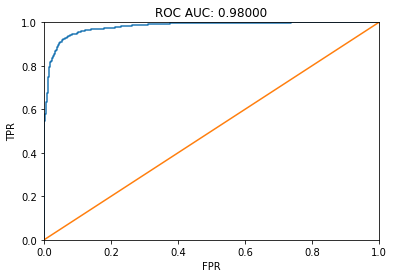


MLPClassifier(activation='logistic', hidden_layer_sizes=(50,),
              learning_rate_init=0.1, max_iter=100, random_state=4399) on TEST
Accuracy: 0.921
Precision: 0.910
Recall: 0.905
f1_score: 0.908

[[407  29]
 [ 31 295]] 



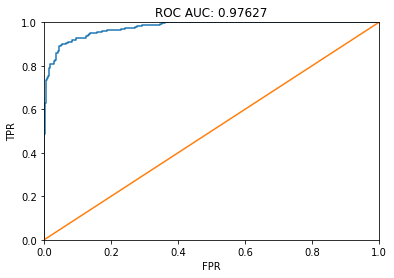

In [47]:
nn = MLPClassifier(hidden_layer_sizes=(50,), activation = 'logistic', learning_rate_init = 0.1, max_iter = 100, random_state = 4399)
nn.fit(X_train_scaled, y_train_resampled)
print_results(nn)

Резкого увеличения количества ошибок на тестовых данных нет. Метрики сопоставимы с методом опорных векторов с линейным ядром. Разница в том, что перцептрон лучше обнаруживает сорт Османчик, а SVM — Каммео. 